In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Dataset

In [2]:
dataset_path = '/content/chicken_duck_dataset'
!unzip -o '/content/chicken_duck_dataset.zip'

Archive:  /content/chicken_duck_dataset.zip
   creating: chicken_duck_dataset/
   creating: chicken_duck_dataset/chicken/
   creating: chicken_duck_dataset/chicken/test/
  inflating: chicken_duck_dataset/chicken/test/0U5DJ4AHL7U8.jpg  
  inflating: chicken_duck_dataset/chicken/test/0YRRH5UO983S.jpg  
  inflating: chicken_duck_dataset/chicken/test/17ZH2WHTIPL8.jpg  
  inflating: chicken_duck_dataset/chicken/test/1O9LZD4GDLEG.jpg  
  inflating: chicken_duck_dataset/chicken/test/1OX6JD87ZL6M.jpg  
  inflating: chicken_duck_dataset/chicken/test/1WHCYYP4QBBB.jpg  
  inflating: chicken_duck_dataset/chicken/test/1ZLB7IELNMCD.jpg  
  inflating: chicken_duck_dataset/chicken/test/21AEDSI4YQ9L.jpg  
  inflating: chicken_duck_dataset/chicken/test/2GGVG9VUE5VP.jpg  
  inflating: chicken_duck_dataset/chicken/test/2IH2F7SXSTFS.jpg  
  inflating: chicken_duck_dataset/chicken/test/2MD30734HGEK.jpg  
  inflating: chicken_duck_dataset/chicken/test/30XSIDP797YK.jpg  
  inflating: chicken_duck_dataset/chic

In [3]:
base_path = '/content/combined_dataset'
os.makedirs(os.path.join(base_path, 'train/chicken'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'train/duck'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'val/chicken'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'val/duck'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'test/chicken'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'test/duck'), exist_ok=True)

# Copy files to the new structure
def copy_files(src_dir, dst_dir):
    if os.path.exists(src_dir):
        for filename in os.listdir(src_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                src_file = os.path.join(src_dir, filename)
                dst_file = os.path.join(dst_dir, filename)
                shutil.copy(src_file, dst_file)

# Copy chicken images
copy_files(os.path.join(dataset_path, 'chicken/train'), os.path.join(base_path, 'train/chicken'))
copy_files(os.path.join(dataset_path, 'chicken/val'), os.path.join(base_path, 'val/chicken'))
copy_files(os.path.join(dataset_path, 'chicken/test'), os.path.join(base_path, 'test/chicken'))

# Copy duck images
copy_files(os.path.join(dataset_path, 'duck/train'), os.path.join(base_path, 'train/duck'))
copy_files(os.path.join(dataset_path, 'duck/val'), os.path.join(base_path, 'val/duck'))
copy_files(os.path.join(dataset_path, 'duck/test'), os.path.join(base_path, 'test/duck'))

In [4]:
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                count += 1
    return count

# Count images
chicken_train_count = count_images(os.path.join(base_path, 'train/chicken'))
duck_train_count = count_images(os.path.join(base_path, 'train/duck'))
total_train = chicken_train_count + duck_train_count

chicken_val_count = count_images(os.path.join(base_path, 'val/chicken'))
duck_val_count = count_images(os.path.join(base_path, 'val/duck'))
total_val = chicken_val_count + duck_val_count

chicken_test_count = count_images(os.path.join(base_path, 'test/chicken'))
duck_test_count = count_images(os.path.join(base_path, 'test/duck'))
total_test = chicken_test_count + duck_test_count

print(f"Training: {total_train} images ({chicken_train_count} chicken, {duck_train_count} duck)")
print(f"Validation: {total_val} images ({chicken_val_count} chicken, {duck_val_count} duck)")
print(f"Test: {total_test} images ({chicken_test_count} chicken, {duck_test_count} duck)")

Training: 897 images (275 chicken, 622 duck)
Validation: 161 images (52 chicken, 109 duck)
Test: 482 images (172 chicken, 310 duck)


### Preprocessing

In [5]:
img_height, img_width = 224, 224
batch_size = 32
epochs = 10

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Just rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 897 images belonging to 2 classes.
Found 161 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


### Model

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Training

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 618ms/step - accuracy: 0.5450 - loss: 0.7784 - val_accuracy: 0.7937 - val_loss: 0.4902
Epoch 2/10
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8750 - loss: 0.4226

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8750 - loss: 0.4226 - val_accuracy: 0.7937 - val_loss: 0.4824
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 405ms/step - accuracy: 0.8168 - loss: 0.4427 - val_accuracy: 0.8938 - val_loss: 0.3384
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8750 - loss: 0.3538 - val_accuracy: 0.8938 - val_loss: 0.3361
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - accuracy: 0.8860 - loss: 0.3354 - val_accuracy: 0.9312 - val_loss: 0.2644
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9062 - loss: 0.2388 - val_accuracy: 0.9187 - val_loss: 0.2643
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 743ms/step - accuracy: 0.8920 - loss: 0.2564 - val_accuracy: 0.9375 - val_loss: 0.2254
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9062 - loss: 0.2269 - val_accuracy: 0.9375 - val_loss: 0.2246
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 746ms/step - accuracy: 0.9410 - loss: 0.2066 - val_accuracy: 0.9563 - val_

### Results

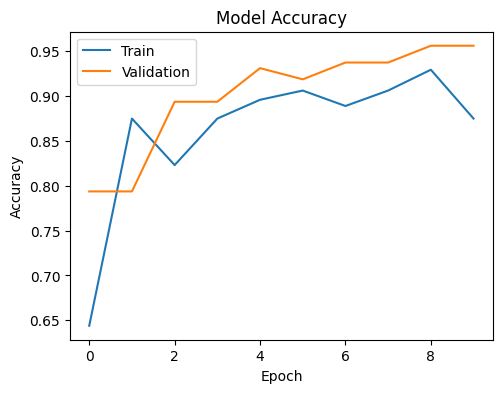

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

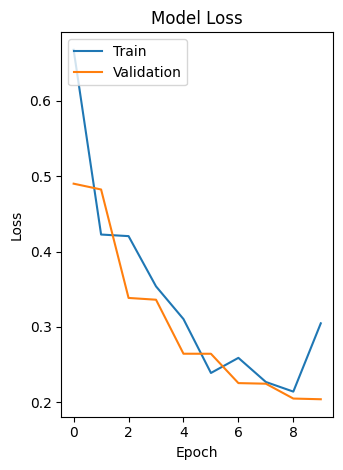

In [13]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.9186 - loss: 0.2176
Test accuracy: 0.9523


In [16]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels
true_classes = test_generator.classes

# Generate classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Classification Report:")
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step
Classification Report:
              precision    recall  f1-score   support

     chicken       0.98      0.88      0.93       172
        duck       0.94      0.99      0.96       310

    accuracy                           0.95       482
   macro avg       0.96      0.94      0.95       482
weighted avg       0.95      0.95      0.95       482

